# Data: 

* **First source:**

https://github.com/wdw21/songbook

446 xml files with songs in Polish, all these files come from the 21WDW (scouts group) songbook written over the years by various guitarists. 


* **Second source:**

https://github.com/qamil95/spiewnik

1006 latex files with songs in Polish come from Cracow's songbook of "around the mountains" songs

* Songs can be repeated in both sources 

* Each song has a title and lyrics, but also (not all of them) artists/ creator and other information

* I am interested in the lyrics of the songs and I try split into clusters

* First of all, I have to extract the data I am interested in from both types of files



In [211]:
# #all imports, remove unused on the finish

# data manipulation and visualization
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.figure_factory as ff
# import plotly.graph_objects as go
# import seaborn as sns


# genaral libraries
import os
# import requests
import re
# from math import sin, cos, sqrt, atan2, radians
from collections import Counter

#libraries for nlp
import nltk
from stempel import StempelStemmer

# algorithms
# from sklearn.datasets import make_blobs, make_moons, make_circles
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
# from sklearn.neighbors import NearestNeighbors

# performance metrics
# from sklearn.metrics import silhouette_score

# for text representation & data preparation
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# agglomerative clustering
# from scipy.spatial.distance import pdist, squareform
# from scipy.cluster.hierarchy import linkage
# from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as sch
import scipy.spatial as ss

#to work with xml files
from lxml import etree
#from enum import Enum
#from distutils.util import strtobool

#to display the entire width of the data frame
pd.set_option('display.max_colwidth', None)

#to display the diagram
from sklearn import set_config
set_config(display="diagram")


## First dataset - xml files

In [212]:
songs = os.listdir("Data/songs/")
songs = [x for x in songs if os.path.splitext(x)[1]==".xml"]
songs #list of xml files in Data directory

['Szesc_blota_stop.xml',
 'Balonik.xml',
 'niepatrznato.xml',
 'Madonna.xml',
 'Nierozdziobai.xml',
 'Przechyly.xml',
 'Znow_wedrujemy.xml',
 'Makatka_z_aniolem.xml',
 'Bieszczadzki_trakt.xml',
 'Ach_kiedy_znowu_rusza.xml',
 'Wiatr,_wiosenny_gitarzysta.xml',
 'Dokad_nas_zaprowadzisz_Panie.xml',
 'Jedyne_co_mam.xml',
 'Miedzy_nami_tyle_sniegu.xml',
 'Dylan_--_pastisz.xml',
 'wasza_wysokosc_kobieto.xml',
 'Chlopaki_nie_placza.xml',
 'Gonic_marzenia.xml',
 'Przyjaciolko.xml',
 'Tawerna_pod_pijana_zgraja.xml',
 'Pocaluj_noc.xml',
 'Zwiewnosc.xml',
 'Zegluj.xml',
 'Easy_Rider.xml',
 'Wielki_Woz.xml',
 'Pan_Kmicic.xml',
 'Broadway.xml',
 'Juz_rozpalilo_sie_ognisko.xml',
 'ciwszyscyludzie.xml',
 'Jesienne_wspominanki.xml',
 'Jaka_cene.xml',
 'Lekcja_historii_klasycznej.xml',
 'Miasto.xml',
 'Placz_moja_wodo.xml',
 'Szkic_do_portretu.xml',
 'Piosenka_dla_Wojtka_Bellona.xml',
 'Wojtka_Bellona_ostatnia_ziemska_podroz_do_Wlodawy.xml',
 'Zabierz_mnie_na_stacje.xml',
 'Piosenka_dla_juniora_i_jego_g

In [213]:
len(songs)

446

In [214]:
# File parsing song in xml (simplified code which I created to generate a epub songbook)

class RowChunk:  # supports chords
    def __init__(self, content=None):
        if content is None:
            self.content = ''
        else:
            self.content = content.strip('\t\n')


class Row:
    def __init__(self, chunks=None):
        self.chunks = [] if chunks is None else chunks


    @staticmethod
    def parseDOM(root):
        if root.text:
            chunks = [RowChunk(content=root.text)]
        else:
            chunks = []
        for chunk in root.getchildren():
            chunks.append(RowChunk(content=chunk.tail))
        return Row(chunks=chunks)

class Block:
    def __init__(self, rows=None):
        self.rows = [] if rows is None else rows

    @staticmethod
    def parseDOM(root, linked=False):
        rows = []
        for child in root.getchildren():
            if child.tag == '{http://21wdh.staszic.waw.pl}bis':
                bis_rows = [Row.parseDOM(row) for row in child.findall('{*}row')]
                rows += bis_rows
            else:
                rows.append(Row.parseDOM(child))

        return Block(rows=rows)


class Song:
    def __init__(self, title='', text_author='', composer='', artist='', translator='', alias='',
                 blocks=None):
        self.title = title if title else ''
        self.text_author = text_author if text_author else ''
        self.composer = composer if composer else ''
        self.artist = artist if artist else ''
        self.translator = translator if translator else ''
        self.alias = alias if alias else ''
        self.blocks = [] if blocks is None else blocks


    @staticmethod
    def parseDOM(root):
        # A child of 'lyric' element may either be a text block, a reference to a text block (e.g. to a chorus), or a tablature.
        text_blocks = root.findall('{*}lyric/{*}block')

        def elementTextOrNone(elem):
            return elem.text if elem is not None else None

        def flatten(block):
            return Block.parseDOM(block) if 'blocknb' not in block.attrib else Block.parseDOM(
                text_blocks[int(block.attrib['blocknb']) - 1], linked=True)

        blocks = [flatten(block) for block in root.find('{*}lyric').getchildren() if
                  block.tag != '{http://21wdh.staszic.waw.pl}tabbs']

        return Song(
            title=root.get('title'),
            text_author=elementTextOrNone(root.find('{*}text_author')),
            composer=elementTextOrNone(root.find('{*}composer')),
            artist=elementTextOrNone(root.find('{*}artist')),
            translator=elementTextOrNone(root.find('{*}translator')),
            alias=elementTextOrNone(root.find('{*}alias')),
            blocks=blocks
        )


def parse_song_xml(path):
    tree = etree.parse(path)
    song = Song.parseDOM(tree.getroot())
    return song


In [215]:
# creating Data Frame df_songs with title amd lyrics, each song in 
df_songs_1=pd.DataFrame(columns=["title", "lyrics", "text_author", "composer", "artist"])
for song in songs:
    
    song=parse_song_xml('Data/songs/'+song)
    title=song.title

    lyrics=""
    for block in song.blocks:
        for row in block.rows:
            for chunk in row.chunks:
                lyrics+=chunk.content
            lyrics+=' '
    text_author=song.text_author
    composer=song.composer
    artist=song.artist
    
    new_row={"title": [title], "lyrics": [lyrics], "text_author": [text_author], "composer": [composer], "artist": [artist]}
    
    df_songs_1=pd.concat([df_songs_1,pd.DataFrame(new_row)], ignore_index=True)
    

In [216]:
df_songs_1

title  \
0                        Sześć błota stóp   
1                                 Balonik   
2                    Nie patrz na to miła   
3                                 Madonna   
4                Nie rozdziobią nas kruki   
..                                    ...   
441                     Noc niespodzianek   
442                       Idąc zawsze idź   
443  Trzy pierścienie dla królów elfów...   
444                           Nadaremność   
445              Ballada o smutnym skinie   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             lyrics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                           Sześć błota stóp Sześć błota stóp Uderz w bęben już Bo nadszedł mój czas Wrzućcie mnie do wody Na wieczną wachcę trza nam gdzie Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp Ściągnijcie flagę w dół Uszyjcie worek mi Dwie kule przy nogach Ostatni ścieg bez krwi no i Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp Na wachcie więcej już Nie ujrzycie chyba mnie Kończę ziemską podróż Do Hilo dotrę wnet tam gdzie Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp A ląd daleko jest Przed wami setki mil A mnie pozostało Do lądu kilka chwil no i Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp Sześć błota stóp, sześć błota stóp, sześć błota stóp    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Płacze dziewczynka, Balon uciekł jej, Ludzie mówią -- nie płacz, A balonik hen. Płacze dziewczyna, Chłopca trzeba jej, Ludzie mówią -- nie płacz, A balonik hen. Płacze kobieta, Mąż porzucił ją, Ludzie mówią -- nie płacz, A balonik hen. Płacze staruszka, Życie moje wróć! A baloni

## Second dataset - tex (latex) files

In [217]:
path="Data/songs2/"
#os.remove(path+'.DS_Store')
catalog_list = os.listdir(path)

In [218]:
df_songs_2=pd.DataFrame(columns=["title", "lyrics", "text_author", "composer", "artist"])
for catalog in catalog_list:
    if os.path.isfile(os.path.join(path, catalog,'.DS_Store')):
        os.remove(os.path.join(path, catalog,'.DS_Store'))
    for song in os.listdir(os.path.join(path, catalog)):
        
        with open(os.path.join(path, catalog, song), "r") as f:
            text=f.read()
          
        #I extract lyrics
        x=re.findall("{textn?}([\\W\\w]+)\\\\end{textn?}", text)
        x=re.sub("\\\\[\w]+({[^}]+})?"," ", x[0]) #Remove "\vin", "\hfill"," "\break" and others     
        x=x.replace("\\\\"," ") #Remove "\\"
        lyrics=x 
        
        #I extract title of song
        title=re.findall("\\\\tytul{([^}]+)}", text)[0]
        
        authors="".join(re.findall("\\\\tytul{[^}]+}{([^}]*)}{[^}]+}", text))
        
        #I extract author of lyrics:
        if authors.find("muz.")==-1 and authors.find("sł.")!=-1:
            text_author=re.findall("sł. ([^\n^\d]*)", authors)[0]
        elif authors.find("muz.")==-1 and authors.find("sł.")==-1 and authors.find("tłum.")!=-1:
            text_author=re.findall("(tłum. [^\n^\d]*)", authors)[0]
        elif authors.find("muz.")!=-1 and authors.find("sł.")==-1 and authors.find("tłum.")!=-1:
            text_author=re.findall("(tłum. [^\n^\d]*)", authors)[0]
            if authors[0]=="t":
                text_author=text_author[:authors.find("muz.")-2]
        else:                           
            text_author=re.findall("sł. ([^\\n^\\d]*), muz.|sł. i muz. ([^\\n]+)", authors)
            if text_author:
                text_author=text_author[0][0]+text_author[0][1]      
        text_author="".join(text_author)
        
        #I extract composer of song:
        composer="".join(re.findall("muz. ([^\\n^\\d^,]*)", authors))
        
        #I extract an artist performing a song:
        artist="".join(re.findall("\\\\tytul{[^}]+}{[^}]*}{([^}]+)}", text))
        
        #I add a raw with song to DataFrame
        new_row={"title": [title], "lyrics": [lyrics], "text_author": [text_author], "composer": [composer], "artist": [artist]}
        df_songs_2=pd.concat([df_songs_2,pd.DataFrame(new_row)], ignore_index=True)     

df_songs_2

title  \
0                      Rajd idzie, rajd   
1     Bieszczady (Tu w dolinach wstaje)   
2                      Goniąc kormorany   
3              Szkoda, że Cię tu nie ma   
4                   Pocztówka z Beskidu   
...                                 ...   
1001                               Czas   
1002             Preludium dla Leonarda   
1003        Czas zupełnie jakby nie mój   
1004                            Scarlet   
1005                       Dla Michasia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    lyrics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    \n    „Olaboga! Co się dzieje?!” – woła Maciejowa \n    kury jaja pogubiły, mleko traci krowa, \n    koty gdzieś się pochowały i szczekają psy, \n    pewnie słońca zaciemnienie będzie w całej wsi.\n\n      A to rajd idzie, rajd! Rajd idzie, rajd! \n      Już się wciska w opłotki, po stodołach gra. \n      Niewidzialna jakaś siła ludzi naprzód gna, \n      a to rajd idzie, idzie rajd.\n\n    Krowy gęby rozdziawiły niby dziury w cieście: \n    po co łazi to po polach zamiast siedzieć w mieście? \n    Ni do wideł się nie nada, ni do cepa tyż, \n    a garbate to i chude, jakby sadził ryż.\n\n      A to rajd idzie…\n\n    Wody w studni już zabrakło, gęba żarem płonie, \n    wiadro migiem to wypije, ino chyci w dłonie, \n    zsiadłe mleko z kartoflami cięgiem by to jadł, \n    i wydziwia, że to niby cudny jest ten świat.\n\n      A to rajd idzie\n   
1                                                                                                                                                                                                                                                                                                

## Combination of two Datasets

In [219]:
df_songs=pd.concat([df_songs_1,df_songs_2], ignore_index=True)
df_songs

title  \
0                Sześć błota stóp   
1                         Balonik   
2            Nie patrz na to miła   
3                         Madonna   
4        Nie rozdziobią nas kruki   
...                           ...   
1447                         Czas   
1448       Preludium dla Leonarda   
1449  Czas zupełnie jakby nie mój   
1450                      Scarlet   
1451                 Dla Michasia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    lyrics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Sześć błota stóp Sześć błota stóp Uderz w bęben już Bo nadszedł mój czas Wrzućcie mnie do wody Na wieczną wachcę trza nam gdzie Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp Ściągnijcie flagę w dół Uszyjcie worek mi Dwie kule przy nogach Ostatni ścieg bez krwi no i Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp Na wachcie więcej już Nie ujrzycie chyba mnie Kończę ziemską podróż Do Hilo dotrę wnet tam gdzie Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp A ląd daleko jest Przed wami setki mil A mnie pozostało Do lądu kilka chwil no i Sześć błota stóp Sześć błota stóp Dziewięć sążni wody I sześć błota stóp Sześć błota stóp, sześć błota stóp, sześć błota stóp    
1                                                                                                                                                                                                                                                                                                                                                                  

## Cleaning text

In [220]:
# text cleaning function
def clean_text(text):
    res = re.sub(r'[^\w\s]', '', text) # removes what is not letter, digit or space
    res = re.sub(r'\d', '', res) # removes digits
    res = re.sub(r'\n', '', res) # removes newlines
    res = re.sub(r'\t', '', res) # removes tabs
    res = re.sub(r' +', ' ', res) # removes unnecessary spaces
    res = res.lower() # changes letters to lowercase
    return res

In [221]:
df_songs.shape

(1452, 5)

In [222]:
#Executing the clean_text function on song lyrics
for i in range(0,df_songs.shape[0]):
    df_songs.lyrics[i]=clean_text(df_songs.lyrics[i])

In [223]:
df_songs.tail()

title  \
1447                         Czas   
1448       Preludium dla Leonarda   
1449  Czas zupełnie jakby nie mój   
1450                      Scarlet   
1451                 Dla Michasia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 lyrics  \
1447                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               czas przebudzony o czasie oczy przeciera widzi że pora targać za uszy rozleniwione budziki i słyszę co dzień jak się stara chociaż nie nakręca go nikt nadać zegarom roztargnionym właściwy rytm i słyszę co dzień jak spokojnie przechodzi do porządku świata nad moją ziemią obiecaną kolejny raz czas rozbiegany jak co dnia przystaje co jakiś czas żeby przytaknąć zegarom tak tak właśnie tak czas postarzały przedwcześnie gaśnie powieki zamyka za chwilę zaśnie na skraju ziewającego budzika wtedy dotykam twoich dłoni sklejam co się skleić da noc czasem sprzyja pokryjomu takim jak ja   
1448                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             na parterze w mojej chacie mieszkał kiedyś taki facet który dnia pewnego cicho do mnie rzekł gdy zachwycisz się dziewczyną nie podrywaj jej na kino ale patrząc w oczy szepnij słowa te jestem taki samotny jak palec albo pies kocham wiersze stachury i stary dobry jazz szczęścia w życiu nie miałem rzucały mnie dziewczyny szukam cichego portu gdzie okręt mój zawinie po tych słowach z miłosierdzia padła już niejedna twierdza i niejedna cnota poszła chyżo w las ryba bierze na robaki a panienka na tekst taki który szepczę cicho patrząc prosto w twarz jestem taki samotny gdy szał pierwszych zrywów minął zakochałem się w dziewczynie z którą dziś na całe życie zostać chce chciałem rzec będziemy razem zrozumiała mnie od razu i jak echo wyszeptała słowa te jes

In [224]:
df_songs.lyrics = df_songs.lyrics.apply(clean_text)

In [225]:
df_songs.tail()

title  \
1447                         Czas   
1448       Preludium dla Leonarda   
1449  Czas zupełnie jakby nie mój   
1450                      Scarlet   
1451                 Dla Michasia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 lyrics  \
1447                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               czas przebudzony o czasie oczy przeciera widzi że pora targać za uszy rozleniwione budziki i słyszę co dzień jak się stara chociaż nie nakręca go nikt nadać zegarom roztargnionym właściwy rytm i słyszę co dzień jak spokojnie przechodzi do porządku świata nad moją ziemią obiecaną kolejny raz czas rozbiegany jak co dnia przystaje co jakiś czas żeby przytaknąć zegarom tak tak właśnie tak czas postarzały przedwcześnie gaśnie powieki zamyka za chwilę zaśnie na skraju ziewającego budzika wtedy dotykam twoich dłoni sklejam co się skleić da noc czasem sprzyja pokryjomu takim jak ja   
1448                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             na parterze w mojej chacie mieszkał kiedyś taki facet który dnia pewnego cicho do mnie rzekł gdy zachwycisz się dziewczyną nie podrywaj jej na kino ale patrząc w oczy szepnij słowa te jestem taki samotny jak palec albo pies kocham wiersze stachury i stary dobry jazz szczęścia w życiu nie miałem rzucały mnie dziewczyny szukam cichego portu gdzie okręt mój zawinie po tych słowach z miłosierdzia padła już niejedna twierdza i niejedna cnota poszła chyżo w las ryba bierze na robaki a panienka na tekst taki który szepczę cicho patrząc prosto w twarz jestem taki samotny gdy szał pierwszych zrywów minął zakochałem się w dziewczynie z którą dziś na całe życie zostać chce chciałem rzec będziemy razem zrozumiała mnie od razu i jak echo wyszeptała słowa te jes

In [226]:
df_songs.to_csv("Data/df_songs.csv")

In [227]:
DF = pd.read_csv("Data/df_songs.csv", index_col="Unnamed: 0")

In [228]:
DF.head()

title  \
0          Sześć błota stóp   
1                   Balonik   
2      Nie patrz na to miła   
3                   Madonna   
4  Nie rozdziobią nas kruki   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         lyrics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                         sześć błota stóp sześć błota stóp uderz w bęben już bo nadszedł mój czas wrzućcie mnie do wody na wieczną wachcę trza nam gdzie sześć błota stóp sześć błota stóp dziewięć sążni wody i sześć błota stóp ściągnijcie flagę w dół uszyjcie worek mi dwie kule przy nogach ostatni ścieg bez krwi no i sześć błota stóp sześć błota stóp dziewięć sążni wody i sześć błota stóp na wachcie więcej już nie ujrzycie chyba mnie kończę ziemską podróż do hilo dotrę wnet tam gdzie sześć błota stóp sześć błota stóp dziewięć sążni wody i sześć błota stóp a ląd daleko jest przed wami setki mil a mnie pozostało do lądu kilka chwil no i sześć błota stóp sześć błota stóp dziewięć sążni wody i sześć błota stóp sześć błota stóp sześć błota stóp sześć błota stóp    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     płacze dziewczynka balon uciekł jej ludzie mówią nie płacz a balonik hen płacze dziewczyna chłopca trzeba jej ludzie mówią nie płacz a balonik hen płacze kobieta mąż porzucił ją ludzie mówią nie płacz a balonik hen płacze staruszka życie moje wróć a balonik wrócił i błękitny jest    
2  świat jest taki a nie inny i zapewne się nie zmieni ogłosili wczoraj słynni dwaj uczeni a w przypadku słynnych ludzi każda myśl jest całkiem dobra więc ci goście otrzymali zaraz nobla mieli rację jest jak było czyli całkiem nieciekawie w rowie leży pierwsza miłość po zabawie jak się bawić to się bawić krzyż na szyi w 

In [229]:
song_names1=list(DF.title)
song_names=[x[:30] for x in song_names1] #limit the number of characters in the title
song_names1

['Sześć błota stóp',
 'Balonik',
 'Nie patrz na to miła',
 'Madonna',
 'Nie rozdziobią nas kruki',
 'Przechyły',
 'Znów wędrujemy',
 'Makatka z aniołem',
 'Bieszczadzki trakt',
 'Ach, kiedy znowu ruszą dla mnie dni',
 'Wiatr, wiosenny gitarzysta',
 'Dokąd nas zaprowadzisz Panie',
 'Jedyne co mam',
 'Między nami tyle śniegu',
 'Dylan -- pastisz',
 'Wasza Wysokość Kobieto',
 'Chłopaki nie płaczą',
 'Gonić marzenia',
 'Przyjaciółko',
 'Tawerna pod pijaną zgrają',
 'Pocałuj noc',
 'Zwiewność',
 'Żegluj',
 'Easy Rider',
 'Wielki Wóz',
 'Pan Kmicic',
 'Broadway',
 'Już rozpaliło się ognisko',
 'Ci wszyscy ludzie',
 'Jesienne wspominanki',
 'Jaką cenę...',
 'Lekcja historii klasycznej',
 'Miasto',
 'Płacz moja wodo',
 'Szkic do portretu',
 'Piosenka dla Wojtka Bellona',
 'Wojtka Bellona ostatnia ziemska podróż do Włodawy',
 'Zabierz mnie na stację',
 'Piosenka dla juniora i jego gitary',
 'Kochać',
 'Jestem mały miś',
 'Krajka (pełna wersja)',
 'Bellonika z miastem',
 'Mucha w szklance lemoni

In [230]:
#Converting text into a list of words
lyrics_list = [nltk.word_tokenize(a, language='polish') for a in DF.lyrics]
lyrics_list

[['sześć',
  'błota',
  'stóp',
  'sześć',
  'błota',
  'stóp',
  'uderz',
  'w',
  'bęben',
  'już',
  'bo',
  'nadszedł',
  'mój',
  'czas',
  'wrzućcie',
  'mnie',
  'do',
  'wody',
  'na',
  'wieczną',
  'wachcę',
  'trza',
  'nam',
  'gdzie',
  'sześć',
  'błota',
  'stóp',
  'sześć',
  'błota',
  'stóp',
  'dziewięć',
  'sążni',
  'wody',
  'i',
  'sześć',
  'błota',
  'stóp',
  'ściągnijcie',
  'flagę',
  'w',
  'dół',
  'uszyjcie',
  'worek',
  'mi',
  'dwie',
  'kule',
  'przy',
  'nogach',
  'ostatni',
  'ścieg',
  'bez',
  'krwi',
  'no',
  'i',
  'sześć',
  'błota',
  'stóp',
  'sześć',
  'błota',
  'stóp',
  'dziewięć',
  'sążni',
  'wody',
  'i',
  'sześć',
  'błota',
  'stóp',
  'na',
  'wachcie',
  'więcej',
  'już',
  'nie',
  'ujrzycie',
  'chyba',
  'mnie',
  'kończę',
  'ziemską',
  'podróż',
  'do',
  'hilo',
  'dotrę',
  'wnet',
  'tam',
  'gdzie',
  'sześć',
  'błota',
  'stóp',
  'sześć',
  'błota',
  'stóp',
  'dziewięć',
  'sążni',
  'wody',
  'i',
  'sześć',


In [231]:
#polish stopwords from: https://countwordsfree.com/stopwords/polish
"""I add worlda "la", "ho", "lala","lalala", "lalalala", "aa", "aaa", "ah", "hej", "yeah", "oh", "uh"
- often used in song for vocalization"""
f = open("Data/stop_words_polish.txt", "r") 
polish_stopwords = f.readlines()
f.close()
polish_stopwords=[x[:-1] for x in polish_stopwords if x[-1:]=='\n']
polish_stopwords

['a',
 'aa',
 'aaa',
 'ach',
 'ah',
 'aj',
 'albo',
 'bardzo',
 'bez',
 'bo',
 'być',
 'ci',
 'cię',
 'ciebie',
 'co',
 'czy',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokąd',
 'dość',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dziś',
 'dzisiaj',
 'gdyby',
 'gdzie',
 'go',
 'hej',
 'ho',
 'ich',
 'ile',
 'im',
 'inny',
 'ja',
 'ją',
 'jak',
 'jakby',
 'jaki',
 'je',
 'jeden',
 'jedna',
 'jedno',
 'jego',
 'jej',
 'jemu',
 'jeśli',
 'jest',
 'jestem',
 'jeżeli',
 'już',
 'każdy',
 'kiedy',
 'kierunku',
 'kto',
 'ku',
 'la',
 'lalala',
 'lalalala',
 'lalalalala',
 'lub',
 'ma',
 'mają',
 'mam',
 'mi',
 'mmm',
 'mmmm',
 'mną',
 'mnie',
 'moi',
 'mój',
 'moja',
 'moje',
 'może',
 'mu',
 'my',
 'na',
 'nam',
 'nami',
 'nas',
 'nasi',
 'nasz',
 'nasza',
 'nasze',
 'natychmiast',
 'nią',
 'nic',
 'nich',
 'nie',
 'niego',
 'niej',
 'niemu',
 'nigdy',
 'nim',
 'nimi',
 'niż',
 'obok',
 'od',
 'około',
 'on',
 'ona',
 'one',
 'oni',
 'ono',
 'owszem',
 'po',
 'pod',
 

In [232]:
#I remove stopwords (polish) from all songs
lyrics_list = [[w for w in a if w not in polish_stopwords] for a in lyrics_list]
lyrics_list[0]

['sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'uderz',
 'bęben',
 'nadszedł',
 'czas',
 'wrzućcie',
 'wody',
 'wieczną',
 'wachcę',
 'trza',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'dziewięć',
 'sążni',
 'wody',
 'sześć',
 'błota',
 'stóp',
 'ściągnijcie',
 'flagę',
 'dół',
 'uszyjcie',
 'worek',
 'kule',
 'nogach',
 'ostatni',
 'ścieg',
 'krwi',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'dziewięć',
 'sążni',
 'wody',
 'sześć',
 'błota',
 'stóp',
 'wachcie',
 'ujrzycie',
 'chyba',
 'kończę',
 'ziemską',
 'podróż',
 'hilo',
 'dotrę',
 'wnet',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'dziewięć',
 'sążni',
 'wody',
 'sześć',
 'błota',
 'stóp',
 'ląd',
 'setki',
 'mil',
 'pozostało',
 'lądu',
 'chwil',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'dziewięć',
 'sążni',
 'wody',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp',
 'sześć',
 'błota',
 'stóp']

In [233]:
#Stemming for words with more than 2 letters
stemmer = StempelStemmer.polimorf()
lyrics_list  = [[stemmer.stem(w) if (stemmer.stem(w)!=None and len(w)>2) else w for w in a] for a in lyrics_list]
lyrics_list

Loading: 100%|██████████████| 11368252/11368252 [00:08<00:00, 1311091.99bytes/s]


[['sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'uderzyć',
  'bęben',
  'nadejść',
  'czas',
  'wrzucić',
  'woda',
  'wieczny',
  'wachcieć',
  'trza',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'ściągnąć',
  'flaga',
  'dół',
  'uszyć',
  'worek',
  'kula',
  'noga',
  'ostatni',
  'ścieg',
  'krew',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'wachta',
  'ujrzeć',
  'chybać',
  'kończyć',
  'ziemski',
  'podróż',
  'hiue',
  'dotrzeć',
  'weć',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'ląd',
  'setki',
  'milić',
  'pozostały',
  'ląd',
  'chwila',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'sześć

In [234]:
#I remove one more time (because they appeared after stemming) stopwords (polish) from all songs
lyrics_list = [[w for w in a if w not in polish_stopwords] for a in lyrics_list]
lyrics_list[0]

['sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'uderzyć',
 'bęben',
 'nadejść',
 'czas',
 'wrzucić',
 'woda',
 'wieczny',
 'wachcieć',
 'trza',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'dziewięć',
 'sążeń',
 'woda',
 'sześć',
 'błoto',
 'stopa',
 'ściągnąć',
 'flaga',
 'dół',
 'uszyć',
 'worek',
 'kula',
 'noga',
 'ostatni',
 'ścieg',
 'krew',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'dziewięć',
 'sążeń',
 'woda',
 'sześć',
 'błoto',
 'stopa',
 'wachta',
 'ujrzeć',
 'chybać',
 'kończyć',
 'ziemski',
 'podróż',
 'hiue',
 'dotrzeć',
 'weć',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'dziewięć',
 'sążeń',
 'woda',
 'sześć',
 'błoto',
 'stopa',
 'ląd',
 'setki',
 'milić',
 'pozostały',
 'ląd',
 'chwila',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'dziewięć',
 'sążeń',
 'woda',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa',
 'sześć',
 'błoto',
 'stopa']

In [235]:
#repair mistakes in stemming
lyrics_list = [[i.replace('gć', 'nagle') for i in w ] for w in lyrics_list]
lyrics_list = [[i.replace('mść', 'mieć') for i in w ] for w in lyrics_list] 
lyrics_list

[['sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'uderzyć',
  'bęben',
  'nadejść',
  'czas',
  'wrzucić',
  'woda',
  'wieczny',
  'wachcieć',
  'trza',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'ściągnąć',
  'flaga',
  'dół',
  'uszyć',
  'worek',
  'kula',
  'noga',
  'ostatni',
  'ścieg',
  'krew',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'wachta',
  'ujrzeć',
  'chybać',
  'kończyć',
  'ziemski',
  'podróż',
  'hiue',
  'dotrzeć',
  'weć',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'ląd',
  'setki',
  'milić',
  'pozostały',
  'ląd',
  'chwila',
  'sześć',
  'błoto',
  'stopa',
  'sześć',
  'błoto',
  'stopa',
  'dziewięć',
  'sążeń',
  'woda',
  'sześć',
  'błoto',
  'stopa',
  'sześć

In [236]:
lyrics_list = [" ".join(a) for a in lyrics_list]

In [237]:
lyrics_list[-1]

'wiedzieć dobry bóg zdarzyć tył kiedyś mały synek spaść niebo akurat iść głowa chmura niedospany skacowany palec dama plecak pełny marzyć grać nauczyć gitara baran przenieść świat smutny kalosz miejsce zagrzać umieć trocha grać malować żyto nieustanna wychylać ramy spaść niebo akurat iść głowa chmura niedospany skacowany palec kiedyś opowiedzieć oto lud oto człowiek jaszczurka skóra kobieta sączyć jad kiedyś naraz dama plecak pełny marzyć przenieść baran parszywy świat'

In [238]:
DF.lyrics=lyrics_list

In [239]:
DF.head()

title  \
0          Sześć błota stóp   
1                   Balonik   
2      Nie patrz na to miła   
3                   Madonna   
4  Nie rozdziobią nas kruki   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             lyrics  \
0                                                                     sześć błoto stopa sześć błoto stopa uderzyć bęben nadejść czas wrzucić woda wieczny wachcieć trza sześć błoto stopa sześć błoto stopa dziewięć sążeń woda sześć błoto stopa ściągnąć flaga dół uszyć worek kula noga ostatni ścieg krew sześć błoto stopa sześć błoto stopa dziewięć sążeń woda sześć błoto stopa wachta ujrzeć chybać kończyć ziemski podróż hiue dotrzeć weć sześć błoto stopa sześć błoto stopa dziewięć sążeń woda sześć błoto stopa ląd setki milić pozostały ląd chwila sześć błoto stopa sześć błoto stopa dziewięć sążeń woda sześć błoto stopa sześć błoto stopa sześć błoto stopa sześć błoto stopa   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                          płakać dziewczynka balon uciec lud mówić płakać balonik henowy płakać dziewczyna chłopiec lud mówić płakać balonik henowy płakać kobieta mąż porzucić lud mówić płakać balonik henowy płakać staruszka żyto wróć balonik wrócić błękitny   
2  świat zmienić ogłosić wczorać słynny uczyć przypadek słynny ludziek myślić całies dobry gość otrzymać zaraza nobel mielić racja całies nieciekawć rów leżeć pierwszy miłość zabawa bawić bawić krzyż szyja dłoń seta niebo zjawić kometa zamknąć oko patrzyć miły powieka znaczyć lepsze widoki siła siła umieć marzyć bawić bawić bieda coraz ważny karabin niić serce zabawa żyć tępy rządzić głowa kretyn kij bejsbolowy patrzyć miły człowiek szanować niech schylać niski głowa chwila moment góry dziękować otworzyć oko całować reszta zamknąć oko miły powieka znaczyć lepsze widoki siła siła umieć marzyć reszta zamknąć oko miły powieka znaczyć lepsze obraza siła siła umieć marzyć   
3                                                                                                                                                                                                                                                                                                                 polskoruski madonna polskostarocerkiewny goreć złoty żywy drewny srebro bizantyjskosłowiański śnieżnobiały sukienko bielić płótno trumienny deska polskoruski madonna polskostarocerkiewny goreć złoty żywy drewny srebro bojarski carski zasmucić kamienny twarz bojarski carski zasmucić chłopski ikona polskoruski madonna polskostarocerkiewny goreć złoty żywy drewny srebro   
4                                                                                                                                                                                                             rozdziobać kruk ni wrony ani rozszarpać sztuka poezje wściekły kwadratoł ruszać brua iść piwo niechybnąć brakować stać miejsce niejeden zginąć niejeden zginąć kwiat omamić forsa ni sława pusty dźwięk ścigać postać realny zjawa tren ru

In [241]:
string = " ".join(lyrics_list)
myDict = dict(Counter(string.split()))
myDict = dict(sorted(myDict.items(), key=lambda x: x[1],reverse=True))

In [242]:
len(myDict) 
#Number of different words after cleaning:

14860

In [245]:
#The most common words
DF_word = pd.DataFrame(myDict.items(), columns=["word", "freq"])
DF_word[:50]

word  freq
0        dzień   785
1        świat   682
2       chcieć   678
3          noc   639
4         czas   549
5     wiedzieć   524
6        wiatr   512
7          iść   500
8        niebo   493
9          raz   474
10        góry   453
11         żyć   436
12        choć   432
13      słońce   412
14         oko   400
15       słowo   392
16       drogi   343
17         móc   336
18       serce   334
19       mówić   327
20     wciążyć   310
21        ręka   295
22        mały   285
23      myślić   281
24      wielki   277
25        żyto   271
26       niech   269
27      miłość   267
28        nikt   264
29         dać   259
30       dobry   253
31      czekać   251
32      chwila   244
33      siebie   244
34       głowa   242
35        grać   242
36         bóg   241
37        dłoń   240
38     gwiazda   239
39        okno   238
40  powiedzieć   237
41      ziemia   232
42      płynąć   232
43       twarz   227
44        znać   221
45        nowy   217
46      miasto   215
47       biały   214
48         tył   208
49        cień   207

In [244]:
list(DF_word.word[:15])

['dzień',
 'świat',
 'chcieć',
 'noc',
 'czas',
 'wiedzieć',
 'wiatr',
 'iść',
 'niebo',
 'raz',
 'góry',
 'żyć',
 'choć',
 'słońce',
 'oko']

**The most popular (>=400) words in this data set are:**

* day (dzień), 
* world (świat),  
* want (chcieć), 
* night (noc),
* time (czas),
* know (wiedzieć),
* wind (wiatr),
* go (iść),    
* sky (niebo), 
* once (raz), 
* mountains (góry), 
* live (żyć), 
* although (choć), 
* sun (słońce),
* eye (oko)

Knowing that it is a collection of songs in the genre of sung poetry, 
scout, tourist and mountain songs, shanties, these words fit the profile.





In [246]:
DF_word.freq.sum() 
#Number of all words after cleaning:

115927

## Text representation
* TF-IDF +SVD +Normalizer - optimal choice for simplicity and effectives
* word embeddings

In [247]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(lyrics_list)
#features = tfidf_matrix.toarray()

In [248]:
tfidf_matrix.shape

(1452, 14837)

In [249]:
tfidf_matrix.data

array([0.01890024, 0.03489317, 0.04016325, ..., 0.06281563, 0.09119363,
       0.07401733])

In [250]:
def get_svd_matrix(n_components, normalize=False):
    svd = TruncatedSVD(n_components=n_components)
    lsa_matrix = svd.fit_transform(tfidf_matrix)
    print(f"Explained Variance: {sum(svd.explained_variance_ratio_)}")
    if normalize:
        normalizer = Normalizer()
        norm_lsa_matrix = normalizer.fit_transform(lsa_matrix)
        return norm_lsa_matrix
    else:
        return lsa_matrix

In [251]:
def get_pca_matrix(n_components, normalize=False):
    pca = PCA(n_components=n_components)
    lsa_matrix = pca.fit_transform(tfidf_matrix)
    print(f"Explained Variance: {sum(pca.explained_variance_ratio_)}")
    if normalize:
        normalizer = Normalizer()
        norm_lsa_matrix = normalizer.fit_transform(lsa_matrix)
        return norm_lsa_matrix
    else:
        return lsa_matrix

In [252]:
svd.components_.shape

(2, 14493)

In [253]:
pca = PCA()
pca.fit(tfidf_matrix.toarray())

PCA()

In [254]:
pca.components_.shape

(1452, 14837)

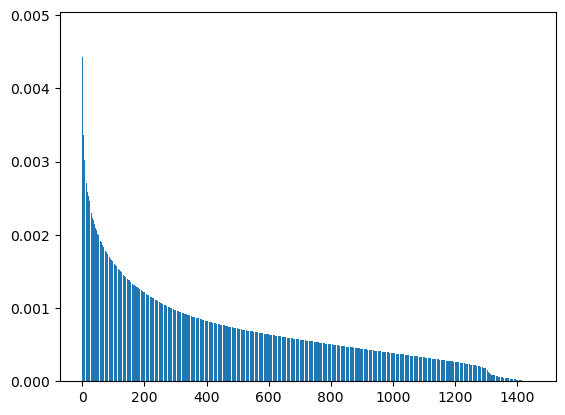

In [255]:
plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
plt.show() 

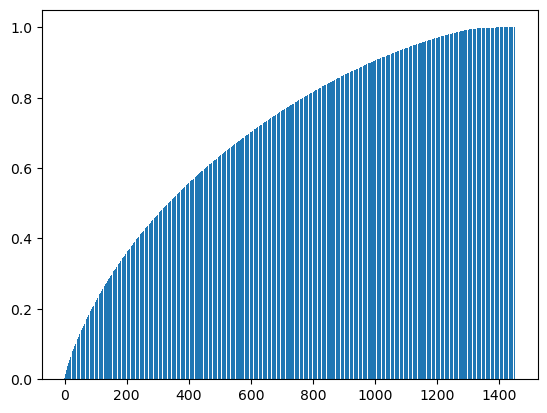

In [256]:
plt.bar(range(pca.n_components_),np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
# pca=PCA(50)
# pca.fit(tfidf_matrix.toarray())
# pca.components_

In [260]:
# I choose 1000 components which explain 90% of variance
norm_lsa_matrix1000=get_svd_matrix(n_components=1000, normalize=True)

Explained Variance: 0.9017729370189599


In [258]:
# I choose 200 components which explain 35% of variance
norm_lsa_matrix200=get_svd_matrix(n_components=200, normalize=True)

Explained Variance: 0.352740028006127


In [259]:
# 500 components which explain 62% of variance
norm_lsa_matrix500=get_svd_matrix(n_components=500, normalize=True)

Explained Variance: 0.6269761317204656


## Plotting dendogram
* grouping pairwise the most similar objects until all objects will be mapped

In [261]:
norm_lsa_matrix1000

array([[ 0.03786658,  0.00166303, -0.00779985, ..., -0.00254822,
        -0.0022753 , -0.01845381],
       [ 0.07871792, -0.03770141,  0.0477305 , ..., -0.01687251,
         0.05748024, -0.0279582 ],
       [ 0.18453233, -0.00665162,  0.0867424 , ...,  0.00499417,
         0.03081031,  0.01444306],
       ...,
       [ 0.1301599 , -0.00711455, -0.0261756 , ...,  0.00517051,
        -0.06414611, -0.01032388],
       [ 0.09442713,  0.00734754,  0.00240957, ...,  0.00685785,
         0.0128927 ,  0.00169143],
       [ 0.1794741 ,  0.0257942 ,  0.05533008, ..., -0.00608449,
         0.00625583,  0.00873369]])

In [263]:
def plot_dendrogram(lsa_matrix,song_names, name_of_file):

    fig = ff.create_dendrogram(lsa_matrix,
                               orientation='left',
                               labels=song_names,
                               linkagefun=lambda x: sch.linkage(x, 'complete'),
                               distfun=lambda x: ss.distance.pdist(x, metric='euclidean')
                              )
    fig.update_layout(width=900, height=12000)
    fig.show()
    fig.write_image(f"images/{name_of_file}.png")
    
plot_dendrogram(norm_lsa_matrix200, song_names, "dendogram")

In [264]:
plot_dendrogram(norm_lsa_matrix1000, song_names, "dendogram1000")

TODO: DESCRIDE DENDOGRAM

Same lyrics but alternative title:

        * "Pod śliwką" and "Anioł i diabeł"
        * "Krajka" and "Krajka (pełna wersja)"
        * "2x Jak dobrze nam"
        * "Kiedy w piątek" and "Ja mam tylko jeden świat"
        * "Pożegnanie 3" and "Pieśń pożegnalna"

Songs based on another:

        * "Opadły mgły" and "Piosenka z pociągu pośpiesznego..."
        * "Jesień idzie" and "Wiesiek idzie"
        * "Coś", "Coś jeszcze" i "Fortepian Szopena" - all of them are short
 
Others:
    
     * "Biukowina I" and "Bukowina II"
     * "Bosman" and "Dziesięć w skali Beauforta"
     * "Pieśń na wejcie" and "Pieśń na wyjście" - both by Stachura,  similar
     * "Gdy się Chrystus rodzi" and "Gloria" - lots of "Gloria" words
     * "Cicha noc" and "Sanctus"
     * "Źródło" and "Źródło II"
     * "Płacz moja wodo" and "Rzeka"
     * "Nuta z Ponidzia" and "Wiosenna pieśń radości" - Lots of "wiosna" words
     * "O krok" and "Kaganek" - Lots of "krok" words
     * "Piosenka bez tytułu" and "Przemijanie", "Powrót" - Lots of "tyle" verses
     * "Chory na wyobraźnię" and "Biały kaftanik" - Lots of "wariat" verses
     * "Madonna" and "Czarna Madonna" ?
     * "Zamknij dom" and "Krąg" ?
     * "Tropiki" and Ballada o trzeźwym diable
     * "Nie lubię" and "Nie lubię wampirów"
     * "Ballada o cześku piekarzu" and "Pytania syna poety"
     * "Obława" and "Obława II"
     * "Idą skauci" and "[***] Zaciągnijcie na oknie..."
     * "Piosenka o papierowym żołnierzyku" and "Ogień"
     * "Mucha w szklance lemoniady" and "Baśń" - lots of "śnij o" words
     * "Moi przyjaciele" and "Hej przyjaciele" and "Piosenka dl aprzyjaciela"- Lots of "przyjaciele" words,similar theme
     * "Piosenka wiosenna" and "Polanka"
     * "Wędrowanie" and "Na błękicie jest polana" - Lots of "powiedz" words

## Clustermap 

In [ ]:
def plot_clustermap(lsa_matrix, songs_names):
    lsa_df = pd.DataFrame(lsa_matrix, index=songs_names)
    plot = sns.clustermap(lsa_df,
                   annot=True,
                   method="complete",
                   metric="euclidean",
                  figsize=(200, 200))
    plot.figure.savefig("images/fig2.png")
 
    plt.show()
    
plot_clustermap(norm_lsa_matrix, song_names)
 

## Plotting 2D & 3D

In [ ]:
lsa_matrix =get_svd_matrix(n_components=2, normalize=False)

fig = px.scatter(data_frame=lsa_matrix,  x=0, y=1,  text=song_names, width=1000, height=1000)
fig.show()

In [ ]:
norm_lsa_matrix=get_svd_matrix(n_components=3,  normalize=True)
fig = px.scatter_3d(data_frame=norm_lsa_matrix, x=0, y=1, z=2, text=song_names)
fig.show()

## Agglomerative Clustering

In [ ]:
norm_lsa_matrix = get_svd_matrix(n_components=50, normalize=True)

In [ ]:
cl=AgglomerativeClustering(n_clusters=None, distance_threshold=1.4)

In [ ]:
clusters=cl.fit_predict(norm_lsa_matrix)
clusters

In [ ]:
dist_df = pd.DataFrame({"Distance": cl.distances_, "nr": list(range(len(cl.distances_)))})
fig = px.line(dist_df, y='Distance', x='nr')
fig.add_hline(2)
fig.show()

In [ ]:
pd.DataFrame({"songs": song_names, "cluster": clusters }).groupby(by="cluster").agg({"songs": pd.Series.unique})

In [ ]:
norm_lsa_matrix = get_svd_matrix(n_components=3, normalize=True)
fig = px.scatter_3d(data_frame=norm_lsa_matrix, x=0, y=1, z=2, text=song_names, color=clusters)
fig.show()

## Text representation

In [ ]:
lyrics_list

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 3))
vectorizer
tf = vectorizer.fit_transform(lyrics_list) #uczę
tf.toarray() #czy coś występuje

In [ ]:
type(vectorizer.vocabulary_)

In [ ]:
vectorizer.vocabulary_

In [ ]:
list(vectorizer.get_feature_names_out())

In [ ]:
# The 5 most frequent words in every song considering frequency of words in the all songs
for i in range(len(lyrics_list)):
    print(i, np.array(tfidf.get_feature_names_out())[
        tfidf_matrix.getrow(i).todense().argsort().A.flatten()[-5:][::-1]
    ])

In [ ]:
DF[DF.title=='Idzie sobie królik'].index

In [ ]:
lyrics_list[78]

In [ ]:
tfidf.get_feature_names_out()

In [ ]:
vectorizer1 = CountVectorizer()
vectorizer1
tf = vectorizer1.fit_transform(lyrics_list) #uczę
tf.toarray() #czy coś występuje

In [ ]:
vectorizer1.vocabulary_

In [ ]:
tf.toarray().shape

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
tf_vectorizer = CountVectorizer()
dtm_tf = tf_vectorizer.fit_transform(lyrics_list)
print(dtm_tf.shape)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
dtm_tfidf = tfidf_vectorizer.fit_transform(lyrics_list)
print(dtm_tfidf.shape)

### Fit Latent Dirichlet Allocation models

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=50, random_state=0)
lda_tf.fit(tfidf_matrix)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=50, random_state=0)
lda_tfidf.fit(tfidf_matrix)

In [ ]:
#hide the warnings in the pink boxes:

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Visualizing the models with pyLDAvis

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

In [ ]:

# import gensim

# dictionary = gensim.corpora.Dictionary.load('newsgroups.dict')
# corpus = gensim.corpora.MmCorpus('newsgroups.mm')
# lda = gensim.models.ldamodel.LdaModel.load('newsgroups_50.model')

from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

lyrics_list1 = [nltk.word_tokenize(a) for a in lyrics_list]
dictionary = corpora.Dictionary(lyrics_list1)
corpus = [dictionary.doc2bow(text) for text in lyrics_list1]
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=50, alpha="auto")

In [ ]:
model.show_topics()

In [ ]:
import pyLDAvis.gensim_models as gensimvis

gensimvis.prepare(model, corpus, dictionary)